# Задача

Найти профиль осесимметричной линзы $z(r)$, образованной поверхностями

$$
z_1(r) = z(r), \quad z_2(r) = -z(r)
$$

из материала с показателем преломления $n$, такой, чтобы параллельный пучок любого диаметра, падающий вдоль оси $z$, сходился в одну точку на оси $z$ на расстоянии $f$ от центра линзы.

# Решение

В статье [1] дано решение задачи, в которой по заданной первой поверхности $z_1(r)$, строится вторая поверхность линзы $z_2(r)$, устроняющая сферическую абберацию.

Согласно обозначениям статьи [1], $z_1(r_a)=z_a$, $z_2(r_b)=z_b$.

Решение задачи задаётся в параметрическом виде (Я записываю решение для паралльельных входящих лучей):

\begin{cases}
r_b=\frac{r_i(z_b-z_a)}{z_i}+r_a,\\
z_b=\frac{h_0+s_1\sqrt{z_1^2[-2nf_i(z_i(z_a-t_b+t(z_i-1))+r_ar_i+tr_i^2)-(r_i(-z_a+t_b+t)+r_az_i)^2+f_i^2+h_1n^2]}}{1-n^2}.
\end{cases}

Где,

\begin{cases}
r_i=-\frac{z_a'\left(n\sqrt{z_a'2+1}\sqrt{\frac{(n^2-1)z_a'^2+n^2}{n^2(z_a'^2+1)}}-1\right)}{n(z_a'^2+1)},\\
z_i=\frac{\sqrt{\frac{(n^2-1)z_a'^2+n^2}{n^2(z_a'^2+1)}}}{\sqrt{z_a'^2+1}}+\frac{z_a'^2}{nz_a'^2+n},\\
f_i=z_a-t_b,\\
h_0=nf_iz_i-n^2(tz_i+z_a)+r_i^2z_a-r_ar_iz_i+z_i^2(t+t_b),\\
h_1=r_a^2+2r_ar_it+(t_b-z_a)^2+t^2(r_i^2+(-1+z_i)^2)-2t(t_b-z_a)(-1+z_i),\\
s_1=\pm 1.
\end{cases}

Введем обозначения:
$$M(r_a):=z_b.$$


Для симметричной линзы должно выполняться (тут начало отсчёта смещено к первой поверхности линзы):

$$z_b=t-z(r_b).$$
Тогда получаем нелинейное функционально-дифференциальное уравнение:

$$M(r)=t-z\left(\frac{r_i\big|_{r_a=r}}{z_i\big|_{r_a=r}}\left(M(r)-z(r)\right)+r\right).$$
Решением которого является $z(r)$.

# Численное решение

В отличие от общего решения [1], в котором параметр $t_b$ задаёт положение фокуса, в случае симметричной линзы $z_2(r)=t-z_1(r)$
перестаёт быть независимым и определяется формой поверхности. Таким образом, фокус симметричной линзы является результатом решения, а не входным параметром задачи.

Сходимость достигнута за 36 итераций
Итерация 36: макс. изменение = 9.774e-03

Аппроксимация поверхности z(r):
-0.5+3.045648e-05*r**0 +1.670217e-02*r**2 -6.767162e-06*r**4 +5.274647e-07*r**6 -1.777914e-08*r**8 +2.125083e-10*r**10 


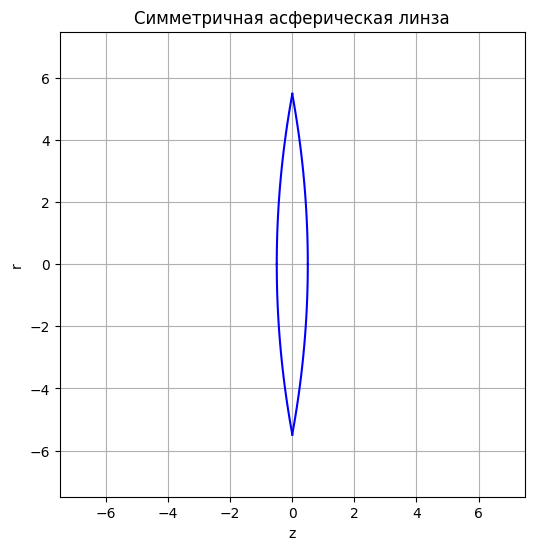

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# =====================================================
# ПАРАМЕТРЫ ЗАДАЧИ
# =====================================================
n = 1.5          # показатель преломления
t = 1.0          # толщина линзы
N = 400          # число узлов по радиусу
lam = 0.05       # параметр релаксации
max_iter = 2000  # максимальное число итераций
tol = 1e-2       # критерий сходимости

# =====================================================
# СЕТКА ПО r
# =====================================================
Rmax_big = 30.0
r = np.linspace(0.0, Rmax_big, N)

# =====================================================
# НАЧАЛЬНОЕ ПРИБЛИЖЕНИЕ
# =====================================================
R0 = 30.0
z = r**2 / (2.0 * R0)      # первая поверхность
M = t - z.copy()           # вспомогательная функция

# =====================================================
# ЧИСЛЕННАЯ ПРОИЗВОДНАЯ dz/dr
# =====================================================
def dz_dr(z, r):
    dz = np.zeros_like(z)
    dz[1:-1] = (z[2:] - z[:-2]) / (r[2:] - r[:-2])
    dz[0] = 0.0
    dz[-1] = dz[-2]
    return dz


# =====================================================
# ИТЕРАЦИОННЫЙ ПРОЦЕСС
# =====================================================
for it in range(max_iter):
    z_old = z.copy()

    # производная поверхности
    zp = dz_dr(z, r)

    # нормаль и угол падения
    norm = np.sqrt(1.0 + zp**2)
    nz = 1.0 / norm
    sin_i = np.sqrt(1.0 - nz**2)

    # закон Снеллиуса
    sin_t = sin_i / n
    cos_t = np.sqrt(1.0 - sin_t**2)

    # наклон луча внутри линзы (dr/dz)
    alpha = sin_t / cos_t

    # интерполяция первой поверхности
    z_interp = interp1d(r, z, fill_value="extrapolate")

    # решение уравнения для M(r)
    for k in range(N):
        for _ in range(5):
            rb = r[k] + alpha[k] * (M[k] - z[k])
            M[k] = t - z_interp(rb)

    # параметрическое задание второй поверхности
    rb = r + alpha * (M - z)
    zb = M.copy()

    # сортировка по радиусу
    idx = np.argsort(rb)
    rb = rb[idx]
    zb = zb[idx]

    # симметрия → новая первая поверхность
    z_new = interp1d(rb, t - zb, fill_value="extrapolate")(r)

    # релаксация
    z = (1.0 - lam) * z + lam * z_new

    # критерий сходимости
    if np.max(np.abs(z - z_old)) < tol:
        print(f"Сходимость достигнута за {it} итераций")
        break

print(f"Итерация {it}: макс. изменение = {np.max(np.abs(z - z_old)):.3e}")


# =====================================================
# ОПРЕДЕЛЕНИЕ АПЕРТУРЫ
# =====================================================
# линза заканчивается там, где z = t/2
diff = z - (t - z)   # = 2z - t

idx_edge = np.where(diff >= 0)[0]
if len(idx_edge) == 0:
    raise RuntimeError("Поверхности не пересеклись — увеличь Rmax_big")

idx_edge = idx_edge[0]

r_phys = r[:idx_edge + 1]
z_phys = z[:idx_edge + 1]

# =====================================================
# ПОСТРОЕНИЕ ЛИНЗЫ
# =====================================================
z1 = z_phys
z2 = t - z_phys
rp = r_phys

# =====================================================
# ЯВНАЯ ФОРМУЛЬНАЯ АППРОКСИМАЦИЯ z(r)
# =====================================================

# используем только r >= 0
r_fit = r_phys
z_fit = z_phys

# степень полинома (чётная!)
deg = 10

# строим матрицу для чётного полинома
powers = np.vstack([r_fit**(2*k) for k in range(deg//2 + 1)]).T

# метод наименьших квадратов
coeffs, *_ = np.linalg.lstsq(powers, z_fit, rcond=None)

# вывод формулы
print("\nАппроксимация поверхности z(r):")
formula = f"{-t/2}" # смещение на t/2 для центрации
for k, a in enumerate(coeffs):
    formula += f"{a:+.6e}*r**{2*k} "
print(formula)


plt.figure(figsize=(6, 8))

# верхняя половина
plt.plot(z1 - t/2,  rp, 'b')
plt.plot(z2 - t/2,  rp, 'b')

# нижняя половина (осевая симметрия)
plt.plot(z1 - t/2, -rp, 'b')
plt.plot(z2 - t/2, -rp, 'b')

plt.xlabel("z")
plt.ylabel("r")
plt.title("Симметричная асферическая линза")

plt.xlim(-r_phys[-1]-2, r_phys[-1]+2)
plt.ylim(-r_phys[-1]-2, r_phys[-1]+2)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

С помощью файла `lense.html` можно смоделировать поверхности, рассчитанные этим скриптом.

[1] González-Acuña R. G. General formula for bi-aspheric singlet lens design free of spherical aberration // Applied Optics. — 2018. — Vol. 57, No. 31. — P. 9341–9345. — DOI:10.1364/AO.57.009341. https://www.researchgate.net/profile/Rafael-G-Gonzalez-Acuna/2